In [1]:
import os
import json
import random
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

BASE = r"C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT"
TRAIN_AUDIO_DIR = os.path.join(BASE, "depression_detection", "data", "train")
TEST_AUDIO_DIR = os.path.join(BASE, "depression_detection", "data", "test")
TRAIN_CSV = os.path.join(BASE, "train_split_Depression_AVEC2017.csv")
FEATURE_DIR = os.path.join(BASE, "depression_detection", "features")
MODEL_DIR = os.path.join(BASE, "depression_detection", "models")
os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)


DEVICE: cpu


In [4]:
SR = 16000
WINDOW_SEC = 5.0
HOP_SEC = 2.5
N_MELS = 64
N_FFT = 1024
HOP_LEN = 256

BATCH_SIZE = 16
EPOCHS = 15
PATIENCE = 6
SEED = 42

def set_seed(s=SEED):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
set_seed()

def extract_mel(y, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LEN):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                         hop_length=hop_length,
                                         n_mels=n_mels, power=2.0)
    return mel.astype(np.float32)


In [5]:
def process_file_to_windows(wav_path, out_dir, window_sec=WINDOW_SEC, hop_sec=HOP_SEC, sr=SR):
    y, _ = librosa.load(wav_path, sr=sr)
    total = len(y)
    window_samples = int(window_sec * sr)
    hop_samples = int(hop_sec * sr)
    starts = list(range(0, max(1, total - window_samples + 1), hop_samples))
    if starts and (starts[-1] + window_samples < total):
        starts.append(total - window_samples)
    if not starts:
        starts = [0]

    saved = []
    for i, s in enumerate(starts):
        chunk = y[s:s+window_samples]
        mel = extract_mel(chunk, sr=sr)
        base = Path(wav_path).stem
        fname = f"{base}_win{i}.npy"
        out_path = os.path.join(out_dir, fname)
        np.save(out_path, mel)
        saved.append(out_path)
    return saved

def preprocess_all_train(train_csv=TRAIN_CSV, audio_dir=TRAIN_AUDIO_DIR, feature_dir=FEATURE_DIR):
    df = pd.read_csv(train_csv)
    mapping = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocess train"):
        pid = str(int(row['Participant_ID']))
        wav_name = f"{pid}_AUDIO.wav"
        wav_path = os.path.join(audio_dir, wav_name)
        if not os.path.exists(wav_path):
            print("Missing:", wav_path)
            continue
        saved = process_file_to_windows(wav_path, feature_dir)
        for p in saved:
            mapping.append({"file": p, "participant": pid, "label": int(row["PHQ8_Binary"])})
    with open(os.path.join(feature_dir, "mapping.json"), "w") as f:
        json.dump(mapping, f)
    print("Total windows saved:", len(mapping))
    return mapping

mapping_path = os.path.join(FEATURE_DIR, "mapping.json")
if not os.path.exists(mapping_path):
    preprocess_all_train()
else:
    print("Mapping exists:", mapping_path)


Mapping exists: C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT\depression_detection\features\mapping.json


In [6]:
with open(mapping_path, "r") as f:
    mapping = json.load(f)
print("Total windows:", len(mapping))

class WindowDataset(Dataset):
    def __init__(self, mapping, max_frames=None):
        self.mapping = mapping
        self.max_frames = max_frames or self._compute_max_frames()
    def _compute_max_frames(self):
        maxf = 0
        for entry in self.mapping:
            arr = np.load(entry["file"])
            maxf = max(maxf, arr.shape[1])
        return maxf
    def __len__(self):
        return len(self.mapping)
    def __getitem__(self, idx):
        entry = self.mapping[idx]
        arr = np.load(entry["file"])
        n_mels, frames = arr.shape
        mf = self.max_frames
        if frames < mf:
            arr = np.pad(arr, ((0,0),(0,mf-frames)), mode='constant')
        elif frames > mf:
            arr = arr[:, :mf]
        x = torch.tensor(arr, dtype=torch.float).unsqueeze(0)
        y = torch.tensor(entry["label"], dtype=torch.float)
        return x, y

dataset = WindowDataset(mapping)
df_map = pd.DataFrame(mapping)
participants = df_map['participant'].unique()
part_labels = df_map.groupby('participant')['label'].first().astype(int)
train_parts, val_parts = train_test_split(participants, test_size=0.2,
                                          random_state=SEED,
                                          stratify=[part_labels.get(p,0) for p in participants])
train_idx = df_map[df_map['participant'].isin(train_parts)].index.tolist()
val_idx = df_map[df_map['participant'].isin(val_parts)].index.tolist()

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Testing first few batches for DataLoader...")
for i, (xb, yb) in enumerate(train_loader):
    print(f"Read batch {i}: x={xb.shape} y={yb.shape}")
    if i >= 2:
        break
print("Batch test done.")


Total windows: 38682
Testing first few batches for DataLoader...
Read batch 0: x=torch.Size([16, 1, 64, 313]) y=torch.Size([16])
Read batch 1: x=torch.Size([16, 1, 64, 313]) y=torch.Size([16])
Read batch 2: x=torch.Size([16, 1, 64, 313]) y=torch.Size([16])
Batch test done.


In [7]:
class RNNBiLSTM(nn.Module):
    def __init__(self, n_mels=N_MELS, rnn_hidden=128, lstm_hidden=128, n_layers=1):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=n_mels,
            hidden_size=rnn_hidden,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.bilstm = nn.LSTM(
            input_size=2 * rnn_hidden,
            hidden_size=lstm_hidden,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = nn.Sequential(
            nn.Linear(2 * lstm_hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.squeeze(1).permute(0, 2, 1)
        out_rnn, _ = self.rnn(x)
        out_lstm, _ = self.bilstm(out_rnn)
        out = out_lstm[:, -1, :]
        logits = self.classifier(out).squeeze(1)
        return logits

model = RNNBiLSTM().to(DEVICE)
print(model)


RNNBiLSTM(
  (rnn): RNN(64, 128, batch_first=True, bidirectional=True)
  (bilstm): LSTM(256, 128, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

best_val = float('inf')
pat = 0
train_losses, val_losses, val_accuracies, val_f1s = [], [], [], []

for epoch in range(1, EPOCHS+1):
    print(f"\n==== Epoch [{epoch}/{EPOCHS}] ====")
    model.train()
    running_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss, preds, trues = 0.0, [], []
    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Validating Epoch {epoch}"):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds.extend(probs.tolist())
            trues.extend(yb.cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_pred = [1 if p > 0.5 else 0 for p in preds]
    val_acc = accuracy_score(trues, val_pred)
    val_f1 = f1_score(trues, val_pred, zero_division=0)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        pat = 0
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "best_new_rnn_bilstm_mel.pth"))
        print("Saved best model.")
    else:
        pat += 1
        if pat >= PATIENCE:
            print("Early stopping")
            break

print("Training completed.")



==== Epoch [1/15] ====


Training Epoch 1:   0%|          | 0/1925 [00:00<?, ?it/s]

Validating Epoch 1:   0%|          | 0/494 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5942 val_loss=0.6055 acc=0.7083 f1=0.0000
Saved best model.

==== Epoch [2/15] ====


Training Epoch 2:   0%|          | 0/1925 [00:00<?, ?it/s]

Validating Epoch 2:   0%|          | 0/494 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5913 val_loss=0.5961 acc=0.7083 f1=0.0000
Saved best model.

==== Epoch [3/15] ====


Training Epoch 3:   0%|          | 0/1925 [00:00<?, ?it/s]

Validating Epoch 3:   0%|          | 0/494 [00:00<?, ?it/s]

Epoch 3: train_loss=0.5907 val_loss=0.6027 acc=0.7083 f1=0.0000

==== Epoch [4/15] ====


Training Epoch 4:   0%|          | 0/1925 [00:00<?, ?it/s]

Validating Epoch 4:   0%|          | 0/494 [00:00<?, ?it/s]

Epoch 4: train_loss=0.5892 val_loss=0.6027 acc=0.7083 f1=0.0000

==== Epoch [5/15] ====


Training Epoch 5:   0%|          | 0/1925 [00:00<?, ?it/s]

Validating Epoch 5:   0%|          | 0/494 [00:00<?, ?it/s]

Epoch 5: train_loss=0.5836 val_loss=0.5963 acc=0.7083 f1=0.0000

==== Epoch [6/15] ====


Training Epoch 6:   0%|          | 0/1925 [00:00<?, ?it/s]

Validating Epoch 6:   0%|          | 0/494 [00:00<?, ?it/s]

Epoch 6: train_loss=0.5744 val_loss=0.6039 acc=0.7085 f1=0.0009

==== Epoch [7/15] ====


Training Epoch 7:   0%|          | 0/1925 [00:00<?, ?it/s]

Validating Epoch 7:   0%|          | 0/494 [00:00<?, ?it/s]

Epoch 7: train_loss=0.5627 val_loss=0.6144 acc=0.7085 f1=0.0017

==== Epoch [8/15] ====


Training Epoch 8:   0%|          | 0/1925 [00:00<?, ?it/s]

Validating Epoch 8:   0%|          | 0/494 [00:00<?, ?it/s]

Epoch 8: train_loss=0.5507 val_loss=0.6253 acc=0.6667 f1=0.1907
Early stopping
Training completed.


In [9]:
import sounddevice as sd
import numpy as np
import torch
import librosa

def record_audio(duration_sec=5, sr=SR):
    print(f"🎙️ Recording {duration_sec} seconds of audio...")
    audio = sd.rec(int(duration_sec * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()
    print("✅ Recording complete.")
    return audio.flatten()

def extract_mel_for_inference(y, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LEN):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                         n_mels=n_mels, power=2.0)
    mel = mel.astype(np.float32)  # keep consistent with training
    return torch.tensor(mel).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, n_mels, frames)

def predict_live_audio(duration_sec=5):
    y = record_audio(duration_sec)
    y = y / (np.max(np.abs(y)) + 1e-9)  # normalize audio amplitude
    mel = extract_mel_for_inference(y)
    mel = mel.to(DEVICE)
    model.eval()
    with torch.no_grad():
        logits = model(mel)
        prob = torch.sigmoid(logits).item()
    label = "Depressed 😔" if prob > 0.5 else "Not Depressed 🙂"
    print(f"🎧 Live Prediction: {label} | Confidence: {prob:.3f}")

# Run live prediction once for 5 seconds of recording
predict_live_audio(duration_sec=5)


🎙️ Recording 5 seconds of audio...
✅ Recording complete.
🎧 Live Prediction: Not Depressed 🙂 | Confidence: 0.100


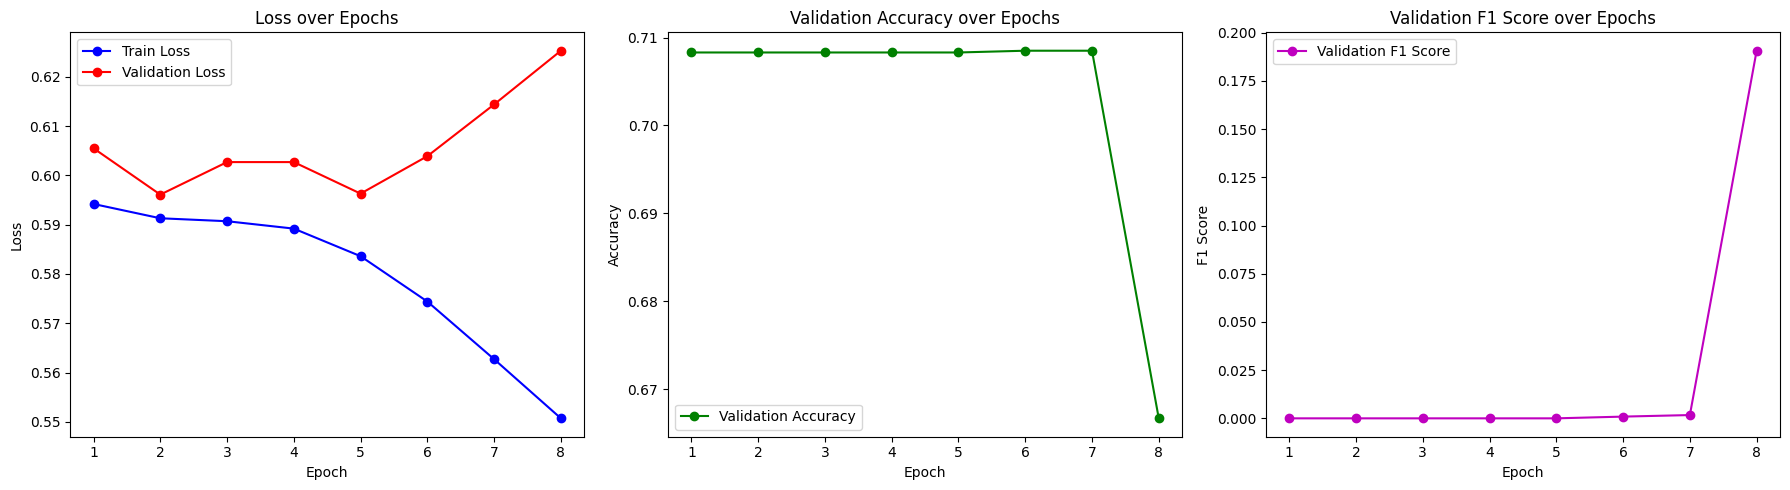

In [10]:
import matplotlib.pyplot as plt

# Example recorded epoch values from your logs
train_losses = [0.5942, 0.5913, 0.5907, 0.5892, 0.5836, 0.5744, 0.5627, 0.5507]
val_losses = [0.6055, 0.5961, 0.6027, 0.6027, 0.5963, 0.6039, 0.6144, 0.6253]
val_accuracies = [0.7083, 0.7083, 0.7083, 0.7083, 0.7083, 0.7085, 0.7085, 0.6667]
val_f1_scores = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0009, 0.0017, 0.1907]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, val_accuracies, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Validation F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs, val_f1_scores, 'mo-', label='Validation F1 Score')
plt.title('Validation F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
